In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
np.random.seed(42)

In [3]:
#store the path of the drug-metabolite file
gen_path = '/Users/neil/Downloads/NCI_genomics.xlsx'
path = '/Users/neil/Desktop/NCI Cell Lines/Integrated Analysis with Rep Meta/Datasets/Gemcitabine_integrated.csv'

In [4]:
#extract the name of the drug

dr = path.split('/')[-1]
drug_name = dr.split('_')[0]
drug_name

'Gemcitabine'

In [5]:
#read the input drug-metabolite integrated data
data = pd.read_csv(path)

#read the input genomics data 
genomics = pd.read_excel(gen_path)

In [6]:
#drop the target drug column
drug = data.pop(f'{drug_name}')

In [7]:
#read the representative set of metabolites

with open('/Users/neil/Desktop/NCI Cell Lines/ModelRunNTimes/outputs/representative_metabolites.txt', 'r+') as f:
    rep_meta = f.read().strip().splitlines()
    
#read the genes

with open('/Users/neil/Desktop/NCI Cell Lines/Integrated Analysis with Rep Meta/list_of_genes.txt', 'r+') as f:
     rep_genes = f.read().strip().splitlines()   
     
rep_genes.extend(rep_meta)

In [8]:
len(rep_meta), len(rep_genes)

(197, 24023)

In [9]:
#select the input features, drop all metadata
X = data.select_dtypes('float64')

#select only the representative metabolites and the gene expression profiles
X = X[rep_genes]

#fill the NaNs with mean of each column
X.fillna(X.mean(), inplace=True)

In [10]:
X.shape

(52, 24023)

In [11]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

In [12]:
#create empty list to store labels and take mean of the response values
#if response value is greater than mean then store 'NR' else store 'R'
#convert the list of labels into a Series

target, drug_mean = [], drug.mean()
for i in drug:
    if i > drug_mean:
        target.append('NR')
    else:
        target.append('R')
y = pd.Series(target)

In [13]:
X.shape, y.shape

((52, 24023), (52,))

In [14]:
#initialize the LabelEncoder instance
le = LabelEncoder()

#encode the labels into 0 and 1 for NR and R respectively
y = pd.Series(le.fit_transform(y))
y.value_counts()

0    27
1    25
Name: count, dtype: int64

In [15]:
#initialize SMOTE instance
smote = SMOTE()

#use SMOTE to create synthetic samples to create a balanced set of data
X, y = smote.fit_resample(X, y)

In [16]:
#initialize StandardScaler for normalization of input features
scaler = StandardScaler()

#normalize the input dataframe
X = pd.DataFrame(data = scaler.fit_transform(X), columns = X.columns)
X.head(2)

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Theaflavin-3-gallate,"PC(14:0/18:4(6Z,9Z,12Z,15Z)) ; PC(14:1(9Z)/18:3(6Z,9Z,12Z)) ; PC(14:1(9Z)/18:3(9Z,12Z,15Z)) ; PC(18:3(6Z,9Z,12Z)/14:1(9Z)) ; PC(18:3(9Z,12Z,15Z)/14:1(9Z)) ; PC(18:4(6Z,9Z,12Z,15Z)/14:0) ; PE(15:0/20:4(5Z,8Z,11Z,14Z)) ; PE(15:0/20:4(8Z,11Z,14Z,17Z)) ; PE(20:4(5Z,8Z,11Z,14Z)/15:0) ; PE(20:4(8Z,11Z,14Z,17Z)/15:0)",Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8
0,4.291102,0.930046,-0.019558,-0.017286,-0.026088,-0.012862,0.068449,0.007503,2.232425,0.145778,...,-1.090428,-0.997624,-0.329298,-1.109200,0.879852,-1.205192,-0.381035,0.395306,-0.651251,1.117370
1,1.974599,0.162525,-0.226900,-0.254072,-0.026088,-0.215932,0.068449,0.007503,-0.935161,4.689074,...,-0.723277,-0.196073,-1.070559,-0.051385,-0.849748,-1.067081,-1.043154,-1.998591,-1.524056,0.753408


In [17]:
X.shape, y.shape

((54, 24023), (54,))

In [18]:
y.value_counts()

1    27
0    27
Name: count, dtype: int64

In [19]:
X.head(2)

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Theaflavin-3-gallate,"PC(14:0/18:4(6Z,9Z,12Z,15Z)) ; PC(14:1(9Z)/18:3(6Z,9Z,12Z)) ; PC(14:1(9Z)/18:3(9Z,12Z,15Z)) ; PC(18:3(6Z,9Z,12Z)/14:1(9Z)) ; PC(18:3(9Z,12Z,15Z)/14:1(9Z)) ; PC(18:4(6Z,9Z,12Z,15Z)/14:0) ; PE(15:0/20:4(5Z,8Z,11Z,14Z)) ; PE(15:0/20:4(8Z,11Z,14Z,17Z)) ; PE(20:4(5Z,8Z,11Z,14Z)/15:0) ; PE(20:4(8Z,11Z,14Z,17Z)/15:0)",Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8
0,4.291102,0.930046,-0.019558,-0.017286,-0.026088,-0.012862,0.068449,0.007503,2.232425,0.145778,...,-1.090428,-0.997624,-0.329298,-1.109200,0.879852,-1.205192,-0.381035,0.395306,-0.651251,1.117370
1,1.974599,0.162525,-0.226900,-0.254072,-0.026088,-0.215932,0.068449,0.007503,-0.935161,4.689074,...,-0.723277,-0.196073,-1.070559,-0.051385,-0.849748,-1.067081,-1.043154,-1.998591,-1.524056,0.753408


In [20]:
#find the indices of the input dataset
indices = X.index.values

#split the dataset into train and test datasets
X_train, X_test, train_index, test_index = train_test_split(X, indices, test_size = 0.20, random_state = 43)
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [21]:
X_train.shape, X_test.shape

((43, 24023), (11, 24023))

In [22]:
y_train.value_counts(), y_test.value_counts()

(1    23
 0    20
 Name: count, dtype: int64,
 0    7
 1    4
 Name: count, dtype: int64)

In [23]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction = []

#define a list to store the number of features being selected each run
num_features = []

#define the model
model = RandomForestClassifier(n_estimators = 150, class_weight = 'balanced')

#define a list to store accuracy, precision and recall 
acc_score, rec_score, pre_score = [], [], []


#run the feature selection and model training and evaluation N times
for i in range(N): 
    #define base estimator for feature selection and fit the training data to it
    base_estimator = RandomForestClassifier(n_estimators = 150, class_weight = 'balanced')
    base_estimator.fit(X_train, y_train)
    
    #compute feature importances
    importances = base_estimator.feature_importances_
    
    #define SelectFromModel to select features based on base estimator provided and use the mean of the feature importances
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform the train and test data using SFM
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X.columns[sfm.get_support(1)])
    
    print(f'Number of features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features.append(len(X_train.columns))
    
    #define the machine learning model and train it
    model.fit(X_train_new, y_train)
    
    #make predictions and other metrics
    y_pred = model.predict(X_test_new)
    acc_score.append(accuracy_score(y_test, y_pred))
    rec_score.append(recall_score(y_test, y_pred, pos_label=1))
    pre_score.append(precision_score(y_test, y_pred, pos_label=1))
    
    #store the probabilites of each run
    prediction.append(model.predict_proba(X_test_new))

    
acc_score = np.array(acc_score)
rec_score = np.array(rec_score)
pre_score = np.array(pre_score)
print(f'Accuracy score: {np.mean(acc_score)}, Standard deviation: {np.std(acc_score)}')
print(f'Recall score: {np.mean(rec_score)}, Standard deviation: {np.std(rec_score)}')
print(f'Precision score: {np.mean(pre_score)}, Standard deviation: {np.std(pre_score)}')

#indice = np.unique(np.array(indice))
prediction = np.array(prediction)
prediction = np.mean(prediction, axis=0)[:, 1]

Number of features selected during iteration 0: 532
Number of features selected during iteration 1: 556
Number of features selected during iteration 2: 542
Number of features selected during iteration 3: 523
Number of features selected during iteration 4: 540
Number of features selected during iteration 5: 557
Number of features selected during iteration 6: 542
Number of features selected during iteration 7: 543
Number of features selected during iteration 8: 536
Number of features selected during iteration 9: 532
Number of features selected during iteration 10: 546
Number of features selected during iteration 11: 562
Number of features selected during iteration 12: 548
Number of features selected during iteration 13: 554
Number of features selected during iteration 14: 536
Number of features selected during iteration 15: 552
Number of features selected during iteration 16: 532
Number of features selected during iteration 17: 551
Number of features selected during iteration 18: 557
Num

In [24]:
features = list(X_train_new.columns)
count = 0
for i in features:
    if i in rep_meta:
        count+=1 #get the number of metabolites selected from the represented features
count, len(features) - count #count the number of genes 

(7, 551)

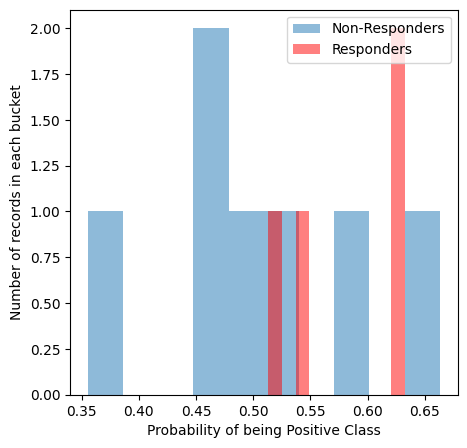

In [25]:
plt.figure(figsize=(5, 5))
plt.hist(prediction[y_test==0], label='Non-Responders', alpha = 0.5)
plt.hist(prediction[y_test==1], label='Responders', alpha=0.5, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [26]:
df_rf_test = X_test.copy()
df_rf_test.loc[test_index, 'test_proba'] = prediction
df_rf_test.loc[test_index, 'target'] = y
df1 = pd.concat([X_train, df_rf_test], sort=False).sort_index()

In [27]:
df1

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,4.291102,0.930046,-0.019558,-0.017286,-0.026088,-0.012862,0.068449,0.007503,2.232425,0.145778,...,-0.329298,-1.109200,0.879852,-1.205192,-0.381035,0.395306,-0.651251,1.117370,NaN,NaN
1,1.974599,0.162525,-0.226900,-0.254072,-0.026088,-0.215932,0.068449,0.007503,-0.935161,4.689074,...,-1.070559,-0.051385,-0.849748,-1.067081,-1.043154,-1.998591,-1.524056,0.753408,NaN,NaN
2,-0.558293,-0.906533,-0.312410,-0.254902,-0.026088,-0.352465,0.068449,-0.546603,-1.020141,0.145778,...,0.116154,-0.981293,-0.076836,-1.092576,-0.245242,-0.450891,-0.537576,-0.179438,NaN,NaN
3,2.288067,0.653863,-0.333542,-0.255443,-0.468842,-0.012862,0.068449,-0.367407,-0.716050,0.145778,...,-0.057217,-0.321127,0.396641,0.202332,-0.331723,-0.720252,0.612271,-0.752516,NaN,NaN
4,1.422942,-0.853103,-0.019558,-0.253562,-0.026088,-0.012862,0.068449,-0.280166,-0.948455,-0.002808,...,-1.159969,0.178395,-1.561983,1.109835,-1.928585,-0.561918,-1.049985,-0.033658,NaN,NaN
5,0.882854,1.101200,-0.317543,-0.255074,-0.026088,-0.012862,0.068449,-0.534448,-0.902481,0.145778,...,-0.349636,0.391128,0.124617,0.666974,-1.322898,1.137144,0.648987,-1.007431,0.355333,0.0
6,0.598913,0.739949,-0.323887,-0.242774,-0.097962,-0.012862,0.068449,-0.510698,-0.665243,0.145778,...,-0.521574,-0.873662,-0.320446,0.202953,0.161147,-0.745175,-0.372991,1.742011,0.496000,0.0
7,0.582442,-0.810983,-0.216767,-0.233255,-0.401277,-0.278142,0.068449,-0.465264,1.340154,3.229058,...,-1.998057,-0.756930,-2.016350,0.789037,-1.530416,-1.162277,-0.966180,-1.347910,NaN,NaN
8,-0.539310,-0.833111,-0.344793,6.944570,6.931059,-0.343810,0.068449,-0.428735,1.703759,-0.569552,...,0.274199,-1.036096,0.004158,-0.808514,-0.383868,0.121300,0.272731,0.068182,NaN,NaN
9,-0.501457,-0.626120,-0.268559,-0.254940,-0.486051,-0.012862,0.068449,0.007503,0.054083,-1.357229,...,0.114309,-1.047157,0.630112,-0.161062,0.420142,0.092369,0.267177,0.621879,NaN,NaN


In [28]:
df1_main = df1.iloc[:51, ]
x = max(prediction[y_test == 0])
df1_main = df1_main.loc[(df1_main['test_proba'] > x)]
df1_main.shape

(0, 24025)

In [29]:
df1_main.index.values #0 40 41 42

array([], dtype=int64)

In [30]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction2 = []

#define a list to store the number of features selected in each iteration
num_features2 = []

#define a list to store accuracy, precision and recall 
model2 = SVC(C=1, gamma=1, probability=True)
acc_score2, rec_score2, pre_score2 = [], [], []

#run a for loop N times and store the prediction probabilities of each run
for i in range(N):
    #define the base estimator for feature selection
    base_estimator = RandomForestClassifier(n_estimators=150, class_weight='balanced')
    base_estimator.fit(X_train, y_train)
    
    #compute the importances of each feature
    importances = base_estimator.feature_importances_
    
    #use SelectFromModel and mean importances to select important features
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform the train-test data using important features
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X_train.columns[sfm.get_support(1)])
    
    print(f'Features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features2.append(len(X_train_new.columns))

    #define the SVM model and train it
    model2.fit(X_train_new, y_train)
    
    #comput predictions
    y_pred2 = model2.predict(X_test_new)
    acc_score2.append(accuracy_score(y_test, y_pred2))
    rec_score2.append(recall_score(y_test, y_pred2, pos_label=1))
    pre_score2.append(precision_score(y_test, y_pred2, pos_label=1))
    prediction2.append(model2.predict_proba(X_test_new))


acc_score2 = np.array(acc_score2)
rec_score2 = np.array(rec_score2)
pre_score2 = np.array(pre_score2)
print(f'Accuracy score: {np.mean(acc_score2)}, Standard deviation: {np.std(acc_score2)}')
print(f'Recall score: {np.mean(rec_score2)}, Standard deviation: {np.std(rec_score2)}')
print(f'Precision score: {np.mean(pre_score2)}, Standard deviation: {np.std(pre_score2)}')


prediction2 = np.array(prediction2)
prediction2 = np.mean(prediction2, axis=0)[:, 1]

Features selected during iteration 0: 541
Features selected during iteration 1: 550
Features selected during iteration 2: 553
Features selected during iteration 3: 551
Features selected during iteration 4: 548
Features selected during iteration 5: 566
Features selected during iteration 6: 551
Features selected during iteration 7: 562
Features selected during iteration 8: 543
Features selected during iteration 9: 537
Features selected during iteration 10: 560
Features selected during iteration 11: 549
Features selected during iteration 12: 563
Features selected during iteration 13: 541
Features selected during iteration 14: 558
Features selected during iteration 15: 571
Features selected during iteration 16: 553
Features selected during iteration 17: 537
Features selected during iteration 18: 551
Features selected during iteration 19: 536
Features selected during iteration 20: 543
Features selected during iteration 21: 541
Features selected during iteration 22: 539
Features selected dur

In [31]:
print(f'Average number of features being selected: {np.mean(num_features2)}')

Average number of features being selected: 548.84


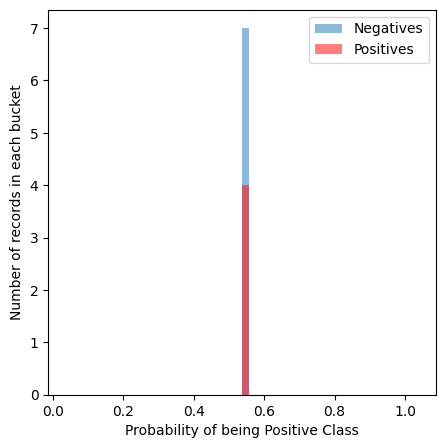

In [32]:
plt.figure(figsize=(5,5))
plt.hist(prediction2[y_test==0], label='Negatives', alpha = 0.5, bins = 50)
plt.hist(prediction2[y_test==1], label='Positives', alpha=0.5, bins = 50, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [33]:
df_svm_test = X_test.copy()
df_svm_test.loc[test_index, 'test_proba'] = prediction2
df_svm_test.loc[test_index, 'target'] = y_test
df2 = pd.concat([X_train, df_svm_test], sort=False).sort_index()

In [34]:
df2_main = df2.iloc[:51, ]
df2_main = df2_main.loc[(df2_main['test_proba'] > max(prediction2[y_test == 0]))]
df2_main

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target


In [35]:
df2_main.index.values #40 41 42

array([], dtype=int64)

In [36]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction3 = []

#define a list to store the number of features being selected in each iteration
num_features3 = []

#define the XGBoost model
model3 = XGBClassifier()

#define a list to store accuracy, precision and recall 
acc_score3, rec_score3, pre_score3 = [], [], []

#run a for loop N times and store the prediction probabilities of each run
for i in range(N):
    #define base estimator to compute feature importances
    base_estimator = XGBClassifier()
    base_estimator.fit(X_train, y_train)
    
    #compute feature importances
    importances = base_estimator.feature_importances_
    
    #define SFM model to select important features
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform train and test sets using best features
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X_test.columns[sfm.get_support(1)])
    
    print(f'Features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features3.append(len(X_train_new.columns))

    #define XGBoost model and train it
    model3.fit(X_train_new, y_train)
    
    #compute predictions
    y_pred3 = model3.predict(X_test_new)
    acc_score3.append(accuracy_score(y_test, y_pred3))
    rec_score3.append(recall_score(y_test, y_pred3, pos_label=1))
    pre_score3.append(precision_score(y_test, y_pred3, pos_label=1))
    prediction3.append(model3.predict_proba(X_test_new))


acc_score3 = np.array(acc_score3)
rec_score3 = np.array(rec_score3)
pre_score3 = np.array(pre_score3)
print(f'Accuracy score: {np.mean(acc_score3)}, Standard deviation: {np.std(acc_score3)}')
print(f'Recall score: {np.mean(rec_score3)}, Standard deviation: {np.std(rec_score3)}')
print(f'Precision score: {np.mean(pre_score3)}, Standard deviation: {np.std(pre_score3)}')


prediction3 = np.array(prediction3)
prediction3 = np.mean(prediction3, axis=0)[:, 1]

Features selected during iteration 0: 29
Features selected during iteration 1: 29
Features selected during iteration 2: 29
Features selected during iteration 3: 29
Features selected during iteration 4: 29
Features selected during iteration 5: 29
Features selected during iteration 6: 29
Features selected during iteration 7: 29
Features selected during iteration 8: 29
Features selected during iteration 9: 29
Features selected during iteration 10: 29
Features selected during iteration 11: 29
Features selected during iteration 12: 29
Features selected during iteration 13: 29
Features selected during iteration 14: 29
Features selected during iteration 15: 29
Features selected during iteration 16: 29
Features selected during iteration 17: 29
Features selected during iteration 18: 29
Features selected during iteration 19: 29
Features selected during iteration 20: 29
Features selected during iteration 21: 29
Features selected during iteration 22: 29
Features selected during iteration 23: 29
Fe

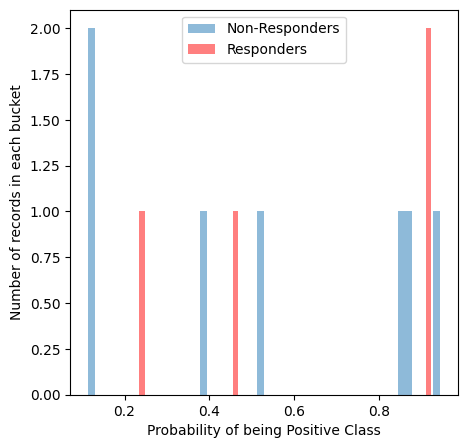

In [37]:
plt.figure(figsize=(5, 5))
plt.hist(prediction3[y_test==0], label='Non-Responders', bins = 50, alpha = 0.5)
plt.hist(prediction3[y_test==1], label='Responders', alpha=0.5, color='r', bins = 50)
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [38]:
df_xg = X_test.copy()
df_xg.loc[test_index, 'test_proba'] = prediction3
df_xg.loc[test_index, 'target'] = y_test
df3 = pd.concat([X_train, df_xg], sort=False).sort_index()
df3

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,4.291102,0.930046,-0.019558,-0.017286,-0.026088,-0.012862,0.068449,0.007503,2.232425,0.145778,...,-0.329298,-1.109200,0.879852,-1.205192,-0.381035,0.395306,-0.651251,1.117370,NaN,NaN
1,1.974599,0.162525,-0.226900,-0.254072,-0.026088,-0.215932,0.068449,0.007503,-0.935161,4.689074,...,-1.070559,-0.051385,-0.849748,-1.067081,-1.043154,-1.998591,-1.524056,0.753408,NaN,NaN
2,-0.558293,-0.906533,-0.312410,-0.254902,-0.026088,-0.352465,0.068449,-0.546603,-1.020141,0.145778,...,0.116154,-0.981293,-0.076836,-1.092576,-0.245242,-0.450891,-0.537576,-0.179438,NaN,NaN
3,2.288067,0.653863,-0.333542,-0.255443,-0.468842,-0.012862,0.068449,-0.367407,-0.716050,0.145778,...,-0.057217,-0.321127,0.396641,0.202332,-0.331723,-0.720252,0.612271,-0.752516,NaN,NaN
4,1.422942,-0.853103,-0.019558,-0.253562,-0.026088,-0.012862,0.068449,-0.280166,-0.948455,-0.002808,...,-1.159969,0.178395,-1.561983,1.109835,-1.928585,-0.561918,-1.049985,-0.033658,NaN,NaN
5,0.882854,1.101200,-0.317543,-0.255074,-0.026088,-0.012862,0.068449,-0.534448,-0.902481,0.145778,...,-0.349636,0.391128,0.124617,0.666974,-1.322898,1.137144,0.648987,-1.007431,0.113868,0.0
6,0.598913,0.739949,-0.323887,-0.242774,-0.097962,-0.012862,0.068449,-0.510698,-0.665243,0.145778,...,-0.521574,-0.873662,-0.320446,0.202953,0.161147,-0.745175,-0.372991,1.742011,0.384057,0.0
7,0.582442,-0.810983,-0.216767,-0.233255,-0.401277,-0.278142,0.068449,-0.465264,1.340154,3.229058,...,-1.998057,-0.756930,-2.016350,0.789037,-1.530416,-1.162277,-0.966180,-1.347910,NaN,NaN
8,-0.539310,-0.833111,-0.344793,6.944570,6.931059,-0.343810,0.068449,-0.428735,1.703759,-0.569552,...,0.274199,-1.036096,0.004158,-0.808514,-0.383868,0.121300,0.272731,0.068182,NaN,NaN
9,-0.501457,-0.626120,-0.268559,-0.254940,-0.486051,-0.012862,0.068449,0.007503,0.054083,-1.357229,...,0.114309,-1.047157,0.630112,-0.161062,0.420142,0.092369,0.267177,0.621879,NaN,NaN


In [39]:
df3_main = df3.iloc[:51, ]
df3_main = df3_main.loc[(df3_main['test_proba'] > max(prediction3[y_test == 0]))]
df3_main

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target


In [40]:
common_list = []
common_list.extend(list(df1_main.index.values))
common_list.extend(list(df2_main.index.values))
common_list.extend(list(df3_main.index.values))

In [41]:
cl = set(common_list)
cl

set()

In [42]:
df1_total = df1.loc[:51, ]
df1_total = df1_total.loc[(df1_total['target'] == 1.0)]
df1_total

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
13,-0.718226,-0.923455,-0.019558,-0.254757,-0.351145,-0.012862,0.068449,0.007503,-0.955548,0.145778,...,0.790122,0.811201,0.231842,-0.082628,1.327048,0.093741,0.438011,-0.844847,0.623333,1.0
18,-0.520785,-0.482273,-0.297364,-0.219747,0.390247,-0.012862,0.068449,-0.436733,0.013959,0.145778,...,-0.919500,-0.051385,-0.316894,-2.301753,-1.964039,-1.272235,-0.507384,-0.608020,0.513333,1.0
31,0.134685,1.469676,-0.019558,0.555830,0.304182,-0.012862,0.068449,0.007503,-0.612872,0.145778,...,-0.383385,-0.966625,-0.908822,-0.585293,-0.430125,-0.891268,-0.948662,-1.303135,0.632533,1.0
39,-0.741170,-0.925091,-0.230136,-0.253969,-0.026088,-0.360441,0.068449,-0.549243,-1.125108,-1.613622,...,-1.115443,0.023264,-0.625973,-0.565267,-1.057078,-1.472855,-1.266511,-0.824760,0.543333,1.0


In [43]:
with open('/Users/neil/Desktop/NCI Cell Lines/Integrated Analysis with Rep Meta/outputs/master_list_metabolomics.txt', 'a+') as f:
    for i in cl:
        f.write(f'{i}\n')

In [44]:
l = []
l.extend(df1_total.index.values)
with open('/Users/neil/Desktop/NCI Cell Lines/Integrated Analysis with Rep Meta/outputs/total_metabolomics.txt', 'a+') as f:
    for i in l:
        f.write(f'{i}\n')